In [1]:
import cv2, os
import numpy as np
# from imgaug import augmenters as iaa
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

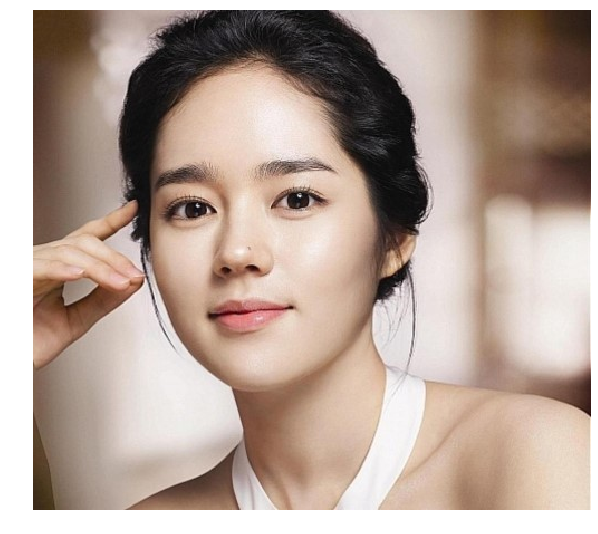

In [70]:
img_path = './img/07.jpg'
dir_path = os.path.dirname(os.path.realpath(img_path))
filename = os.path.basename(img_path)
# out_dir_path = os.path.join(dir_path, filename + '_out')
# os.makedirs(out_dir_path, exist_ok=True)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = img.copy()

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(img)

# Preview Filters

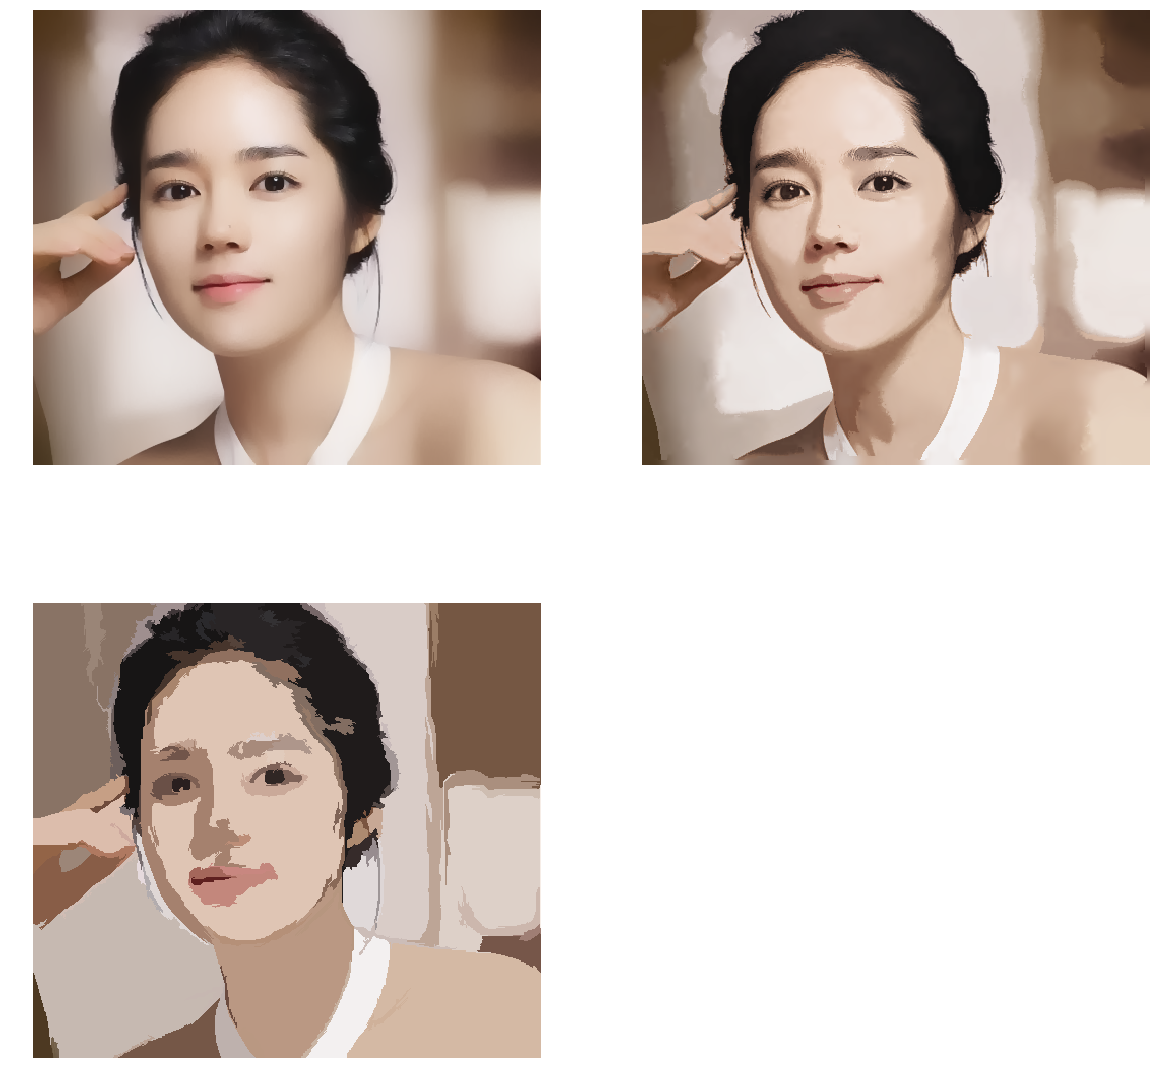

In [9]:
'''
flags –
Edge preserving filters:
    RECURS_FILTER = 1
    NORMCONV_FILTER = 2
sigma_s – Range between 0 to 200.
sigma_r – Range between 0 to 1
'''
epf = cv2.edgePreservingFilter(img, flags=1, sigma_s=60, sigma_r=0.4)

# sp – The spatial window radius.
# sr – The color window radius.
# maxLevel – Maximum level of the pyramid for the segmentation.
msf = cv2.pyrMeanShiftFiltering(img, sp=30, sr=30, maxLevel=3)

'''
scale(float): Free parameter. Higher means larger clusters.
sigma(float): Width (standard deviation) of Gaussian kernel used in preprocessing.
min_size(int): Minimum component size. Enforced using postprocessing.
'''
seg = img.copy()
segments = felzenszwalb(img, scale=300, sigma=0.5, min_size=100)

for i in range(np.max(segments)):
    logical_segment = segments == i
    segment_img = seg[logical_segment]
    seg[logical_segment] = np.mean(segment_img, axis=0)
# seg = cv2.pyrMeanShiftFiltering(seg, sp=30, sr=30, maxLevel=3)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(2, 2, 1).axis('off')
plt.imshow(epf)
fig.add_subplot(2, 2, 2).axis('off')
plt.imshow(msf)
fig.add_subplot(2, 2, 3).axis('off')
plt.imshow(seg)

# Edge Preserving Filter

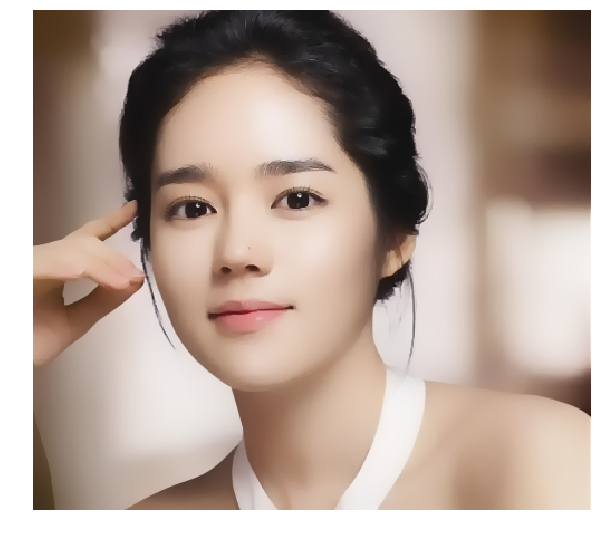

In [71]:
'''
flags –
Edge preserving filters:
    RECURS_FILTER = 1
    NORMCONV_FILTER = 2
sigma_s – Range between 0 to 200.
sigma_r – Range between 0 to 1
'''
result = cv2.edgePreservingFilter(result, flags=1, sigma_s=20, sigma_r=0.4)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)

# Color Adjustment

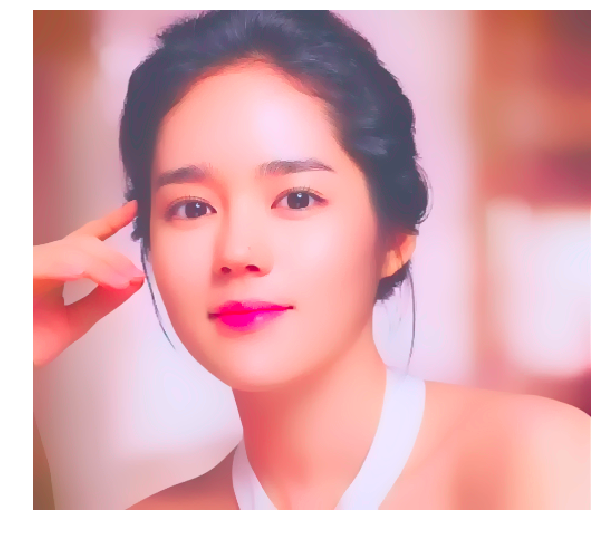

In [72]:
# src_mean = np.array((111, 140.12, 157.45))
# src_stddev = np.array((60.45, 26.26, 23.85))
src_img = cv2.imread('./styles/pink/13597469_153428689000_2.jpg')
src_lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB).astype(np.float32)
src_mean, src_stddev = cv2.meanStdDev(src_lab)

result_lab = cv2.cvtColor(result, cv2.COLOR_RGB2LAB).astype(np.float32)
result_mean, result_stddev = cv2.meanStdDev(result_lab)

result_lab -= result_mean.reshape((1, 1, 3))
result_lab = np.multiply(result_lab, np.divide(src_stddev.flatten(), result_stddev.flatten()).reshape((1, 1, 3)))
result_lab += src_mean.reshape((1, 1, 3))
result_lab = np.clip(result_lab, 0, 255)
result = cv2.cvtColor(result_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)

# Mean Shift Filtering

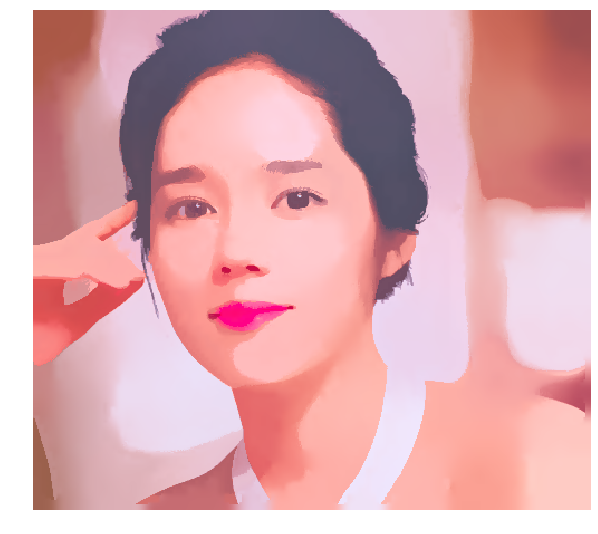

In [73]:
# sp – The spatial window radius.
# sr – The color window radius.
# maxLevel – Maximum level of the pyramid for the segmentation.
result = cv2.pyrMeanShiftFiltering(result, sp=30, sr=30, maxLevel=3)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)

# Image Segmentation and Fill Mean Value

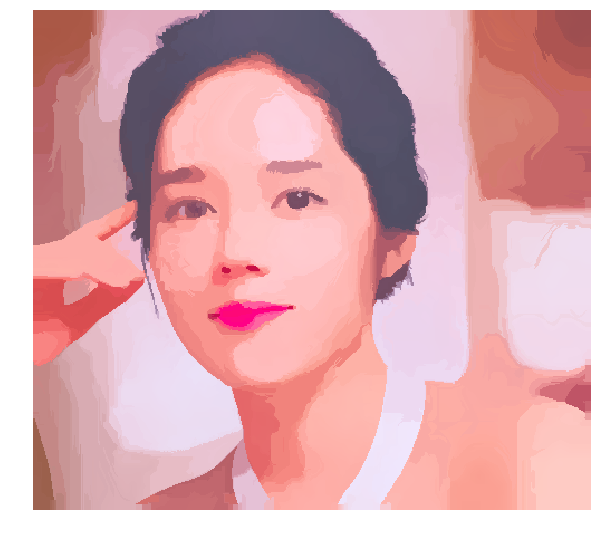

In [68]:
'''
scale(float): Free parameter. Higher means larger clusters.
sigma(float): Width (standard deviation) of Gaussian kernel used in preprocessing.
min_size(int): Minimum component size. Enforced using postprocessing.
'''
segments = felzenszwalb(result, scale=40, sigma=0.4, min_size=10)

for i in range(np.max(segments)):
    logical_segment = segments == i
    segment_img = result[logical_segment]
    result[logical_segment] = np.mean(segment_img, axis=0)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)

# Transform Image

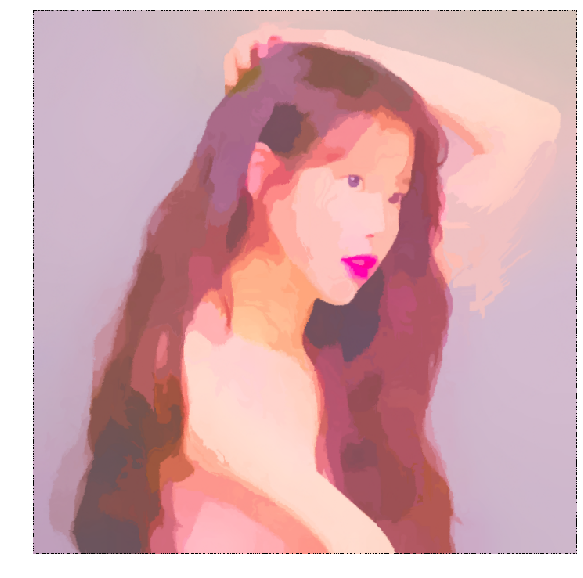

In [148]:
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=0.1),
    iaa.PiecewiseAffine(scale=0.005),
    iaa.ElasticTransformation(alpha=0.2, sigma=0.1),
])

result = seq.augment_image(result)
prev_result = result.copy()

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)

# Merge Texture

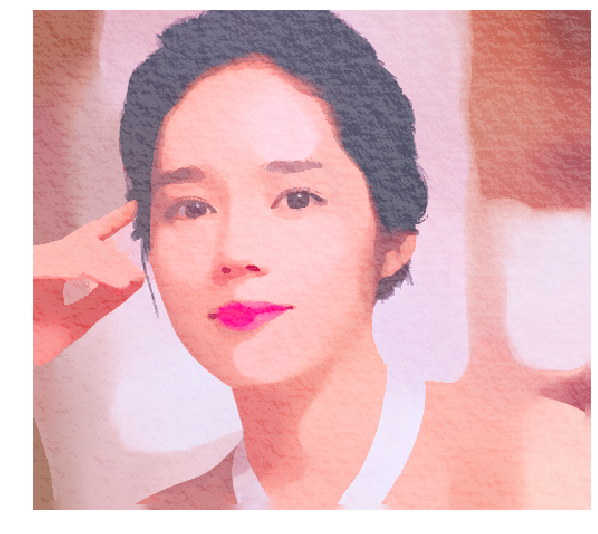

In [74]:
texture = cv2.imread('./assets/texture.jpg', cv2.IMREAD_GRAYSCALE)

if texture.shape[0] > result.shape[0]: # crop
    texture = texture[:result.shape[0], :]
elif texture.shape[0] < result.shape[0]: # pad
    texture = np.pad(texture, ((0, result.shape[0] - texture.shape[0]), (0, 0)), mode='reflect')
if texture.shape[1] > result.shape[1]: # crop
    texture = texture[:, :result.shape[1]]
elif texture.shape[1] < result.shape[1]: # pad
    texture = np.pad(texture, ((0, 0), (0, result.shape[1] - texture.shape[1])), mode='wrap')

texture = np.clip(texture, 210, 255)
result = cv2.merge((result, texture))

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1).axis('off')
plt.imshow(result)